In [70]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.display import Latex, Markdown

In [71]:
from data_model import DataModel

In [72]:
seed = 1

np.random.seed(seed)

N = 1000

In [73]:
class DataModelLinear(DataModel):
    def __init__(self, N: int):
        self.x_1 = np.random.uniform(0, 5, N)
        self.x_2 = np.random.uniform(0, 3, N)
        self.eps = np.random.normal(0, 0.001, N)

        super().__init__(N)

    def generate_x(self) -> pd.DataFrame:
        X = pd.DataFrame({
            "X_1": self.x_1,
            "X_2": self.x_2,
        })
        return X

    def calculate_y(self, X: pd.DataFrame) -> np.ndarray:
        y = 5 * X["X_1"] - 3 * X["X_2"] + self.eps
        return y

    def _true_predictions(self, feature: str, X: pd.DataFrame) -> np.ndarray:
        return super()._true_predictions(feature, X)

    def __str__(self) -> str:
        x_1_str = "$x_1 \sim \mathbb U(0, 5)$"
        x_2_str = "$x_2 \sim \mathbb U(0, 3)$"
        eps_str = "$\epsilon \sim \mathbb N(0, 0.001)$"
        y_str = "$y = 5 \cdot x_1 - 3 \cdot x_2 + \epsilon$"
        return "\n".join([y_str, x_1_str, x_2_str, eps_str])


In [74]:
class DataModelLinearBackdoor(DataModel):
    def __init__(self, N: int):
        self.x_1 = np.random.uniform(0, 5, N)
        self.x_2 = np.random.uniform(0, 3, N) + 0.5 * self.x_1
        self.eps = np.random.normal(0, 0.2 ** 2, N)

        super().__init__(N)

    def generate_x(self) -> pd.DataFrame:
        X = pd.DataFrame({
            "X_1": self.x_1,
            "X_2": self.x_2,
        })
        return X

    def calculate_y(self, X: pd.DataFrame) -> np.ndarray:
        y = 5 * X["X_1"] - 3 * X["X_2"] + self.eps
        return y

    def _true_predictions(self, feature: str, X: pd.DataFrame) -> np.ndarray:
        if feature == "X_1":
            X["X_2"] += 0.5 * X["X_1"]
        return self.calculate_y(X)

    def __str__(self) -> str:
        x_1_str = "$x_1 \sim \mathbb U(0, 5)$"
        x_2_str = "$x_2 \sim \mathbb U(0, 3)$ + $x_1$"
        eps_str = "$\epsilon \sim \mathbb N(0, 0.001)$"
        y_str = "$y = 5 \cdot x_1 - 3 \cdot x_2 + \epsilon$"
        return "\n".join([y_str, x_1_str, x_2_str, eps_str])


In [75]:
class DataModelLinearReversedCausality(DataModel):
    def __init__(self, N: int):
        self.x_1 = np.random.uniform(0, 5, N)
        self.x_2 = np.zeros(N)

        self.eps = np.random.normal(0, 0.2 ** 2, N)

        super().__init__(N)

        self.x_2 = 0.5 * self.y + np.random.uniform(0, 3, N)

    def generate_x(self) -> pd.DataFrame:
        X = pd.DataFrame({
            "X_1": self.x_1,
            "X_2": self.x_2,
        })
        return X

    def calculate_y(self, X: pd.DataFrame) -> np.ndarray:
        y = 5 * X["X_1"] + self.eps
        return y

    def _true_predictions(self, feature: str, X: pd.DataFrame) -> np.ndarray:
        return super()._true_predictions(feature, X)

    def __str__(self) -> str:
        x_1_str = "$x_1 \sim \mathbb U(0, 5)$"
        x_2_str = "$0.5 \cdot y + x_2 \sim \mathbb U(0, 3)$"
        eps_str = "$\epsilon \sim \mathbb N(0, 0.001)$"
        y_str = "$y = 5 \cdot x_1 + \epsilon$"
        return "\n".join([y_str, x_1_str, x_2_str, eps_str])


In [76]:
ml_models = [
        LinearRegression(),
        RandomForestRegressor(n_estimators=100, random_state=seed),
        # SVR(kernel="poly"),
        # MLPRegressor(solver="adam", max_iter=1000, random_state=seed),
]

In [77]:
data_models = [
    DataModelLinear(N),
    DataModelLinearBackdoor(N),
    DataModelLinearReversedCausality(N),
]

In [78]:
def run_experiments(ml_models: list, data_models: list):
    for data_model in data_models:
        print("-" * 150)
        display(Markdown(f"# {data_model.__class__.__name__}"))
        display(Latex(str(data_model)))

        for ml_model in ml_models:
            ml_model.fit(data_model.X, data_model.y)
            score = ml_model.score(data_model.X, data_model.y)

            print(f"{ml_model.__class__.__name__} score: {score}")

            explainer = shap.Explainer(ml_model.predict, data_model.X)
            shap_values = explainer(data_model.X)
            sample_ind = 15

            shap.plots.scatter(shap_values[:, "X_1"], color=shap_values)
            shap.plots.scatter(shap_values[:, "X_2"], color=shap_values)

            shap.plots.waterfall(shap_values[sample_ind], max_display=14)

            shap.plots.bar(shap_values.abs.max(0))

            shap.plots.beeswarm(shap_values)

            print("." * 150)


------------------------------------------------------------------------------------------------------------------------------------------------------


# DataModelLinear

<IPython.core.display.Latex object>

LinearRegression score: 0.9999999822428751


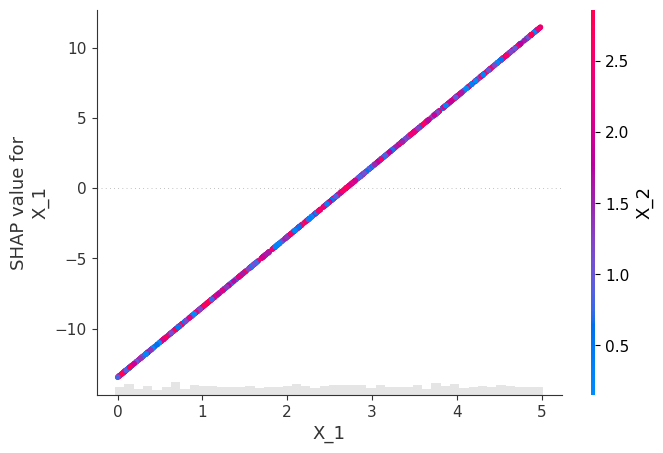

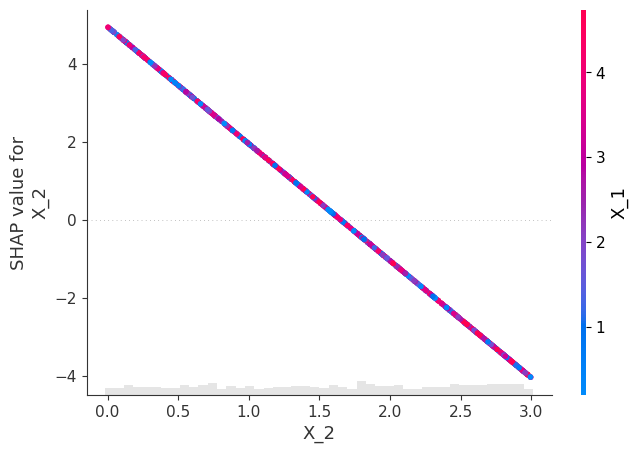

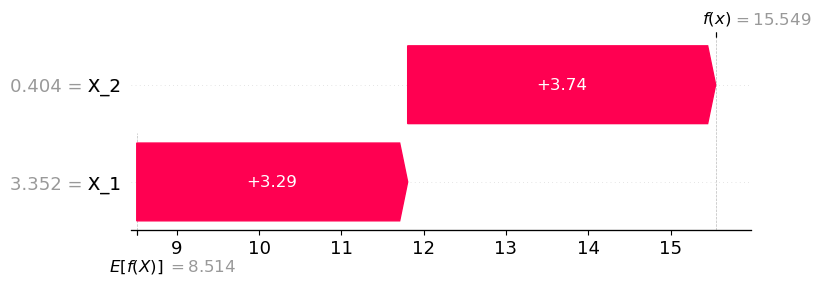

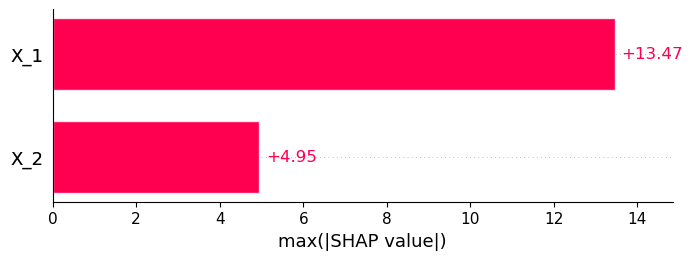

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


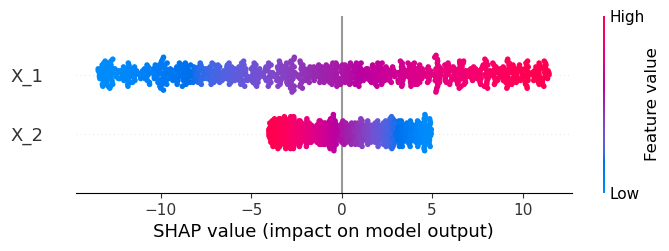

......................................................................................................................................................
RandomForestRegressor score: 0.99985768757416


Exact explainer: 1001it [00:11, 12.07it/s]                         


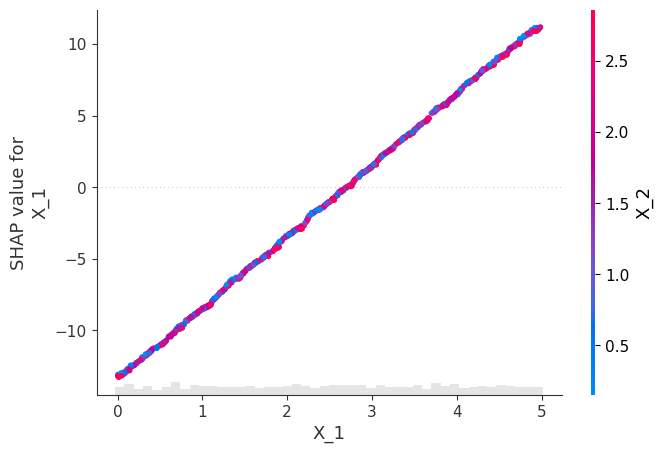

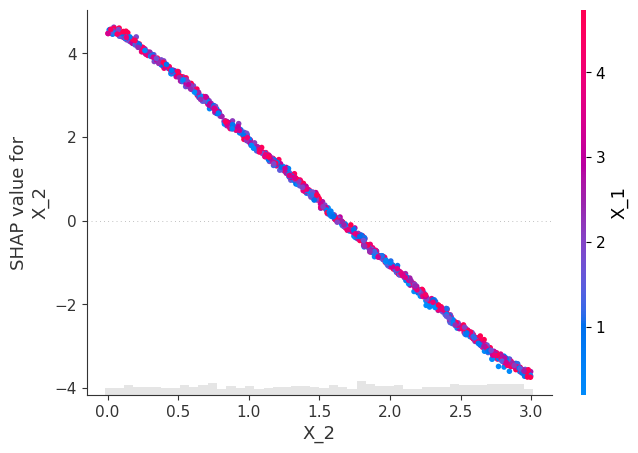

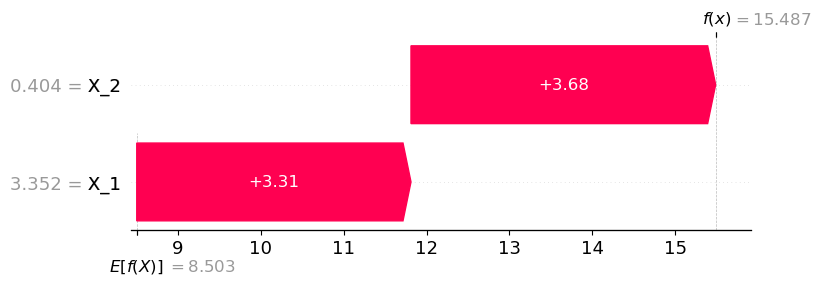

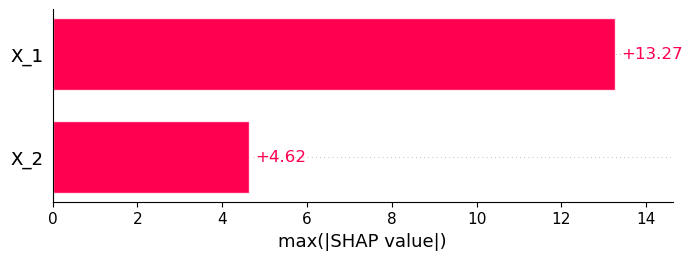

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


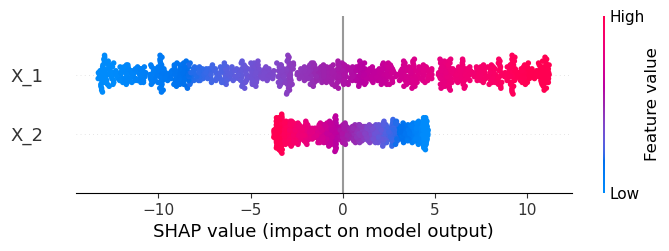

......................................................................................................................................................
------------------------------------------------------------------------------------------------------------------------------------------------------


# DataModelLinearBackdoor

<IPython.core.display.Latex object>

LinearRegression score: 0.999948979868118


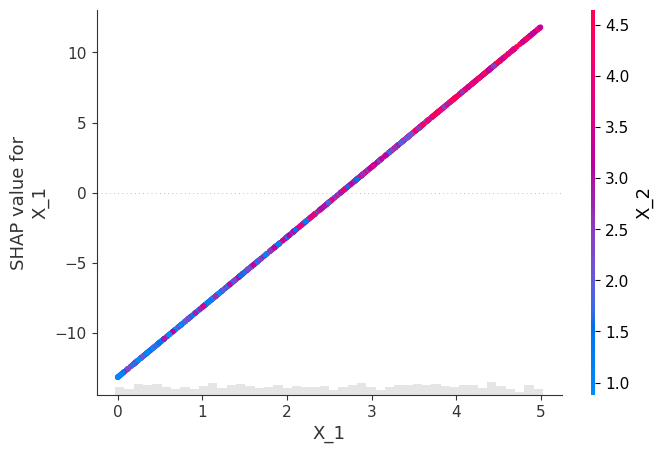

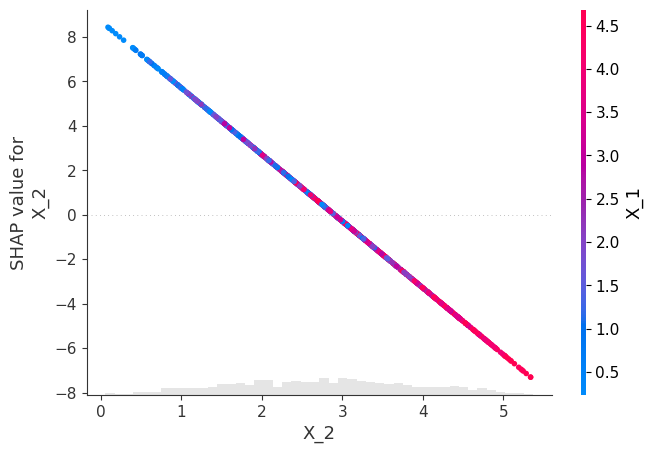

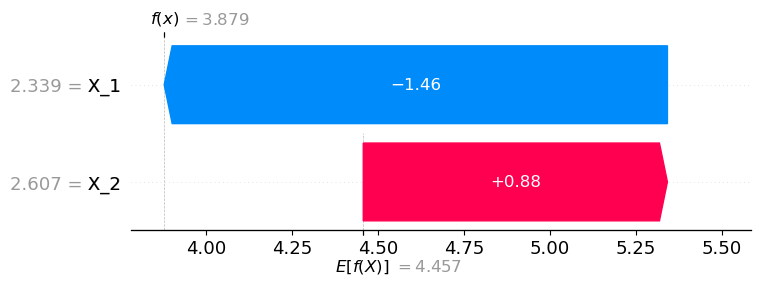

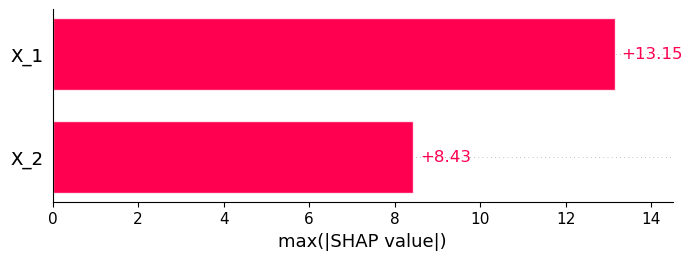

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


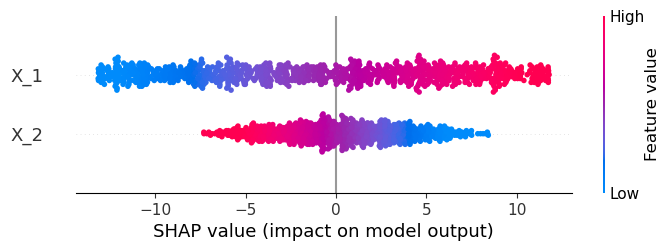

......................................................................................................................................................
RandomForestRegressor score: 0.9997297849893779


Exact explainer: 1001it [00:11, 12.91it/s]                         


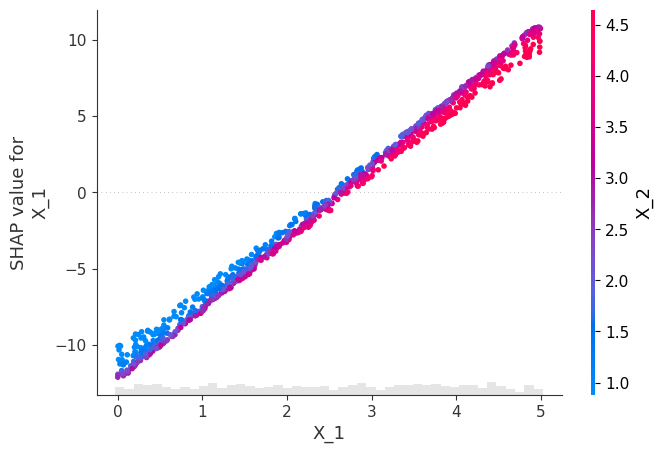

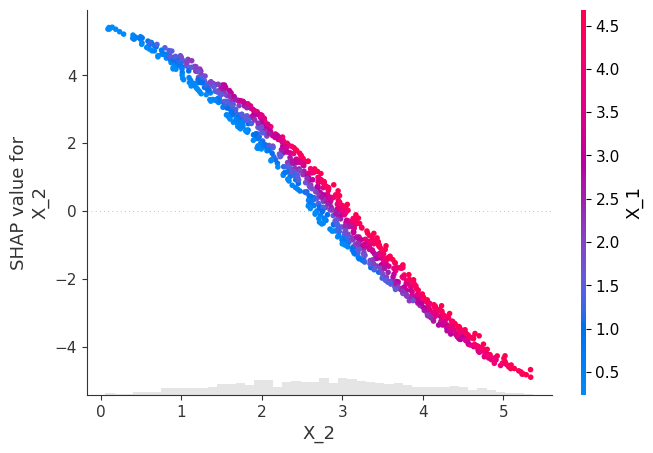

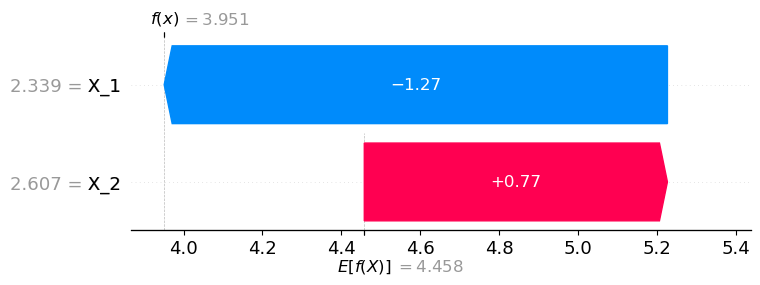

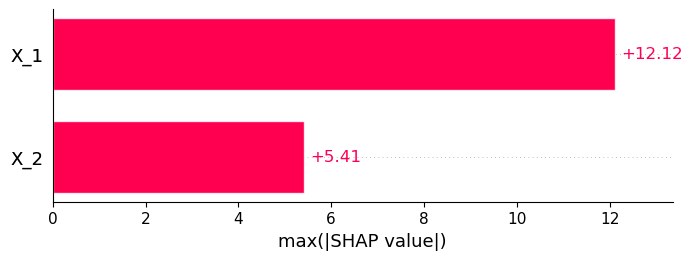

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


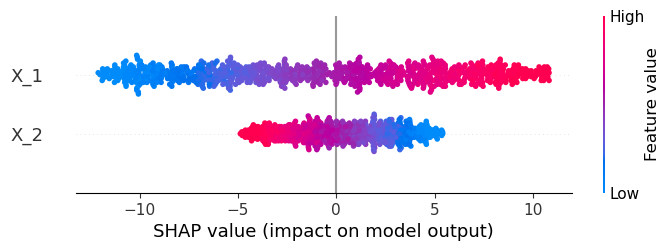

......................................................................................................................................................
------------------------------------------------------------------------------------------------------------------------------------------------------


# DataModelLinearReversedCausality

<IPython.core.display.Latex object>

LinearRegression score: 0.9999698001909202


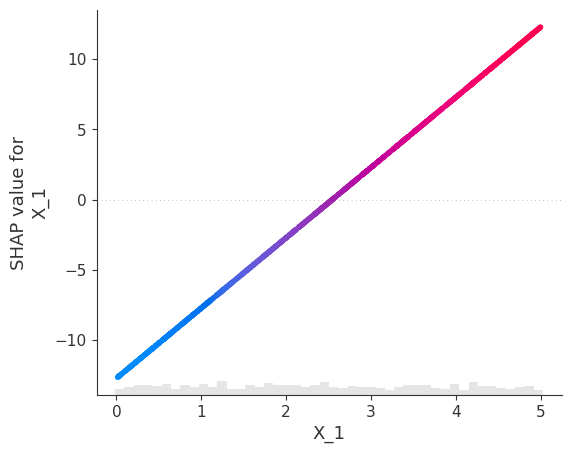

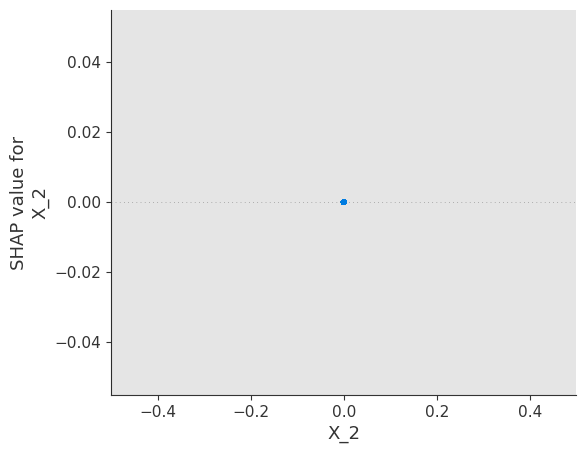

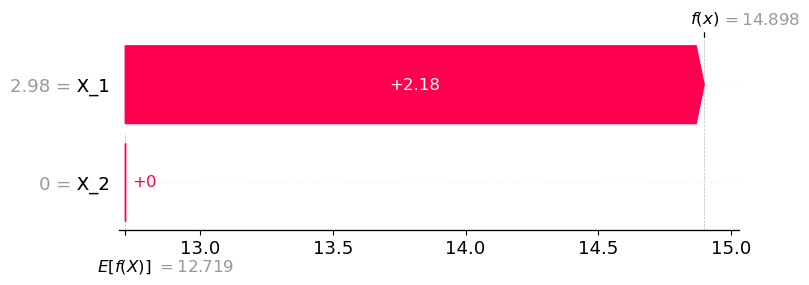

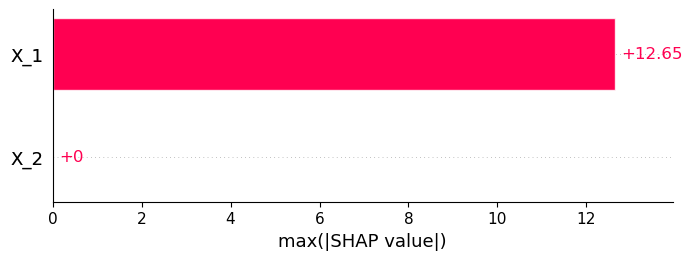

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


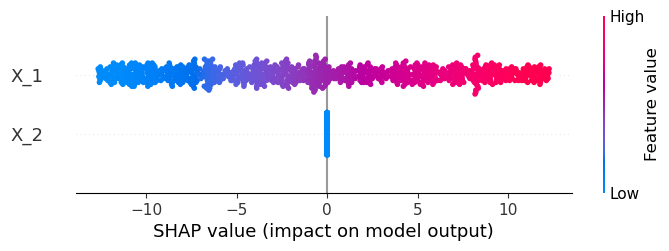

......................................................................................................................................................
RandomForestRegressor score: 0.9999930418747659


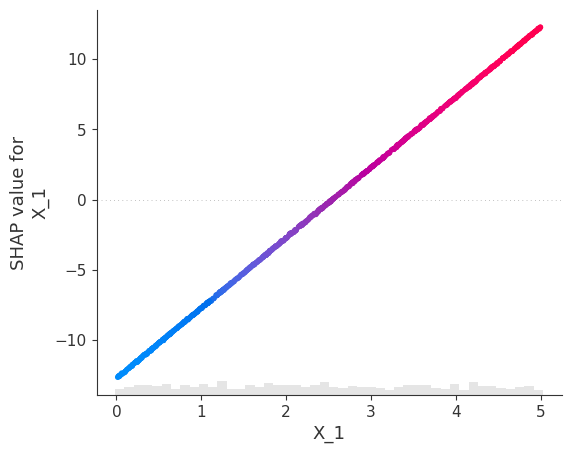

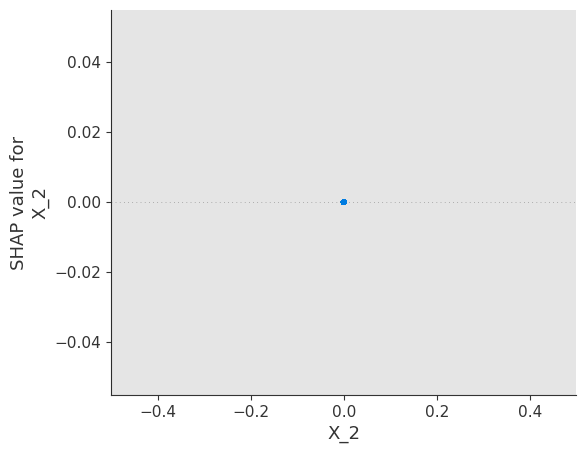

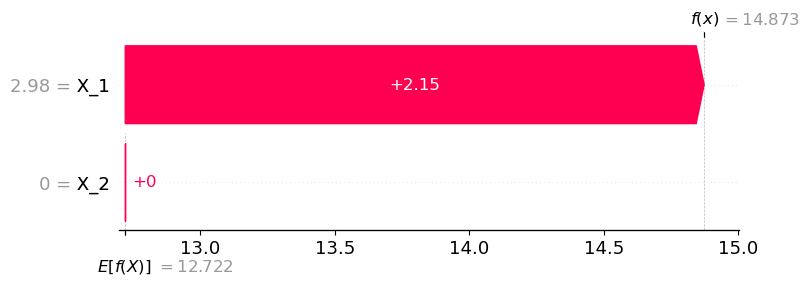

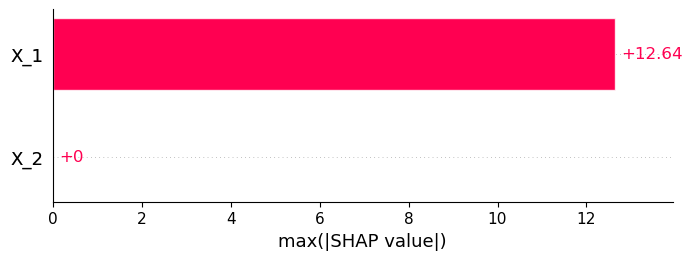

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


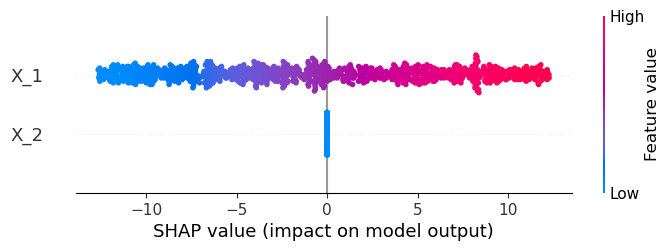

......................................................................................................................................................


In [79]:
run_experiments(ml_models, data_models)